# 심층신경망 (DNN) 만들기
- 손글씨를 분류하는 심층 신경망을 만들어봅시다.
- 파이토치 라이브러리를 사용합니다.
- 코랩 설정의 런타임-하드웨어 가속기에서 `gpu`를 선택하면 더 빨리 실행할 수 있습니다.

In [1]:
import numpy as np
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random

In [2]:
GPU = torch.cuda.is_available() 
device = torch.device("cuda" if GPU else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용

In [3]:
torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

## MNIST 데이터 불러오기

In [4]:
from sklearn.datasets import fetch_openml # 데이터셋을 다운받기 위한 라이브러리
mnist = fetch_openml('mnist_784') # 데이터셋 다운
mnist.target = mnist.target.astype(np.int8) # 타입 변환

print(mnist.data.shape)    # 이미지 데이터 크기
print(mnist.target.shape)  # 라벨(정답) 데이터 크기

(70000, 784)
(70000,)


In [5]:
# 원 핫 인코딩
# 1, 2, 3 등으로 표현된 라벨 데이터를 아래와 같이 변환합니다.
# [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
# [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
# [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
one_hot = enc.fit_transform(mnist.target.reshape(-1, 1)).toarray()

print(one_hot[:5])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [6]:
# 학습 데이터
x_train = mnist.data[:50000]
y_train = mnist.target[:50000]

# 테스트 데이터
x_test = mnist.data[50000:]
y_test = mnist.target[50000:]

print(x_train.shape)
print(y_train.shape)

(50000, 784)
(50000,)


In [7]:
x_train = torch.FloatTensor(x_train).to(device)
x_test = torch.FloatTensor(x_test).to(device)

y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

print(x_train.shape)
print(y_train.shape)

torch.Size([50000, 784])
torch.Size([50000])


## 심층 신경망 모델 만들기
| 계층 이름 | 크기 |
| ---- | -- |
| Input | 784 |
| Dense | 512 |
| ReLU | |
| Dense | 512 |
| Output | 10 |

In [8]:
l1 = torch.nn.Linear((28*28), 512).to(device)
l2 = torch.nn.Linear(512, 10).to(device)
relu = torch.nn.ReLU()

model = torch.nn.Sequential(l1, relu, l2)
model

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=10, bias=True)
)

## 심층 신경망 학습시키기

In [9]:
cost = torch.nn.CrossEntropyLoss().to(device) # 파이토치에 내장된, 분류용 비용 함수입니다.
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # 경사하강법 설정입니다. 여기서 학습율을 조정할 수 있습니다.

In [10]:
epochs = 200
for epoch in range(1, epochs+1):
    optimizer.zero_grad()                # 기울기 초기화
    hypothesis = model(x_train)          # 예측 수행
    cost_val = cost(hypothesis, y_train) # 비용(에러) 계산
    cost_val.backward()                  # 발생한 에러를 역전파
    optimizer.step()                     # 경사하강법

    if epoch % 5 == 1 or epoch == epochs:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(epoch, epochs, cost_val.item()))

Epoch    1/200 Cost: 29.119505
Epoch    6/200 Cost: 76.456612
Epoch   11/200 Cost: 28.792395
Epoch   16/200 Cost: 111.801453
Epoch   21/200 Cost: 1.681556
Epoch   26/200 Cost: 1.162137
Epoch   31/200 Cost: 2.093587
Epoch   36/200 Cost: 1.052900
Epoch   41/200 Cost: 0.843447
Epoch   46/200 Cost: 0.845551
Epoch   51/200 Cost: 0.738678
Epoch   56/200 Cost: 0.625479
Epoch   61/200 Cost: 0.594575
Epoch   66/200 Cost: 0.488430
Epoch   71/200 Cost: 0.443617
Epoch   76/200 Cost: 0.451469
Epoch   81/200 Cost: 0.401306
Epoch   86/200 Cost: 0.400278
Epoch   91/200 Cost: 0.364057
Epoch   96/200 Cost: 0.399635
Epoch  101/200 Cost: 0.339519
Epoch  106/200 Cost: 0.331249
Epoch  111/200 Cost: 0.327048
Epoch  116/200 Cost: 0.321256
Epoch  121/200 Cost: 0.294504
Epoch  126/200 Cost: 0.300839
Epoch  131/200 Cost: 0.283159
Epoch  136/200 Cost: 0.283192
Epoch  141/200 Cost: 0.272128
Epoch  146/200 Cost: 0.295004
Epoch  151/200 Cost: 0.272783
Epoch  156/200 Cost: 0.248189
Epoch  161/200 Cost: 0.237216
Epoch

## 평가하기

In [11]:
with torch.no_grad():  # 학습을 더 이상 진행하지 않음
    pred_train = torch.argmax(model(x_train),1).cpu().data.numpy()
    pred_test = torch.argmax(model(x_test),1).cpu().data.numpy()

print(pred_train[:5])

from sklearn.metrics import accuracy_score # 정확도 측정 라이브러리

train_acc = accuracy_score(y_train.cpu().data, pred_train)
test_acc = accuracy_score(y_test.cpu().data, pred_test)

print("학습 정확도:", train_acc)
print("테스트 정확도:", test_acc)

[5 0 4 1 9]
학습 정확도: 0.93712
테스트 정확도: 0.93345


# 결과 시각화하기

정답
tensor([3, 8, 1, 9, 7, 1, 2, 3, 0, 1], device='cuda:0')
예측
[3 8 1 9 7 1 8 3 0 1]


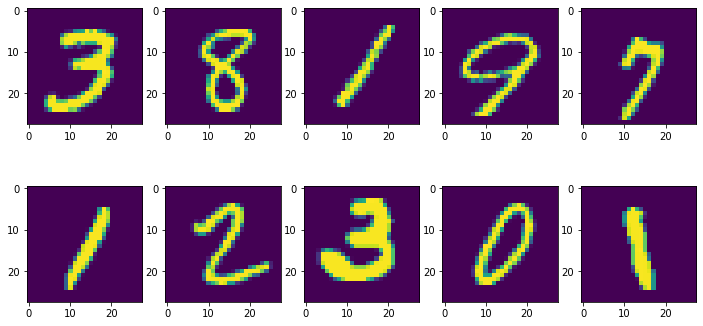

In [13]:
pick = np.random.randint(0, 20000, size=10) # 랜덤한 값 10개 추출

imgs = []
for i in pick:
    img = x_test[i].cpu().data
    img = img.reshape(28, 28)
    imgs.append(img)

print('정답')
print(y_test[pick]) # 정답 출력
print('예측')
print(pred_test[pick])

fig = plt.figure(figsize=(12,6))

for i in range(1, 11):
    sub = fig.add_subplot(2, 5, i)
    sub.imshow(imgs[i-1])